<a href="https://colab.research.google.com/github/shumshersubashgautam/Computer-Aided-Drug-Discovery-Learning/blob/main/6_Maximum_common_substructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/volkamerlab/teachopencadd.git

Cloning into 'teachopencadd'...
remote: Enumerating objects: 17115, done.
remote: Counting objects: 100% (2093/2093), done.
remote: Compressing objects: 100% (969/969), done.
remote: Total 17115 (delta 1309), reused 1786 (delta 1122), pack-reused 15022
Receiving objects: 100% (17115/17115), 849.77 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (11506/11506), done.
Updating files: 100% (468/468), done.


Aim of this tutorial
Clustering and classification of large scale chemical data is essential for navigation, analysis and knowledge discovery in a wide variety of chemical application domains in drug discovery.

In the tutorial 5, we learned how to group molecules (clustering) and found that the molecules in one cluster look similar to each other and share a common scaffold. Besides visual inspection, we will learn here how to calculate the maximum substructure that a set of molecules has in common.

Contents in Theory
Introduction to identification of maximum common substructure in a set of molecules
Detailed explanation of the FMCS algorithm
Contents in Practical
Load and draw molecules
Run the FMCS algorithm with different input parameters
A more diverse set: the EGFR compounds downloaded from ChEMBL
Identification of MCS using interactive cut-off adaption
References
Dalke A, Hastings J., FMCS: a novel algorithm for the multiple MCS problem. J. Cheminf. 2013; 5 (Suppl 1): O6
Raymond JW., Willet P., Maximum common subgraph isomorphism algorithms for the matching of chemical structures. J Comput Aided Mol Des. 2002 Jul; 16(7):521-33
Dalke's website with info on algorithm
RDKit Cookbook documentation on MCS
Theory
Introduction to identification of maximum common substructure in a set of molecules
Maximum common substructure, highlighted

The maximum common structure (MCS) is defined as the largest substructure that appears in two or more candidate molecules.

Finding the MCS = maximum common subgraph isomorphism problem
Has many applications in the field of cheminformatics: similarity search, hierarchical clustering, or molecule alignment
Advantages:
Intuitive
 shared structure among candidates likely to be important
Provides insight into possible activity patterns
Easy visualization by simply highlighting the substructure
Details on MCS algorithms (see review: J Comput Aided Mol Des. 2002 Jul; 16(7):521-33)

Determining an MCS between two or more graphs is an NP-complete problem
Algorithms for exact determination as well as approximations exist
Exact: Maximum-clique, backtracking, dynamic programming
Approximate: Genetic algorithm, combinatorial optimization, fragment storage, ...
Problem reduction: Simplify the molecular graphs
Example of an implementation: FMCS algorithm

Models MCS problem as a graph isomorphism problem
Based on subgraph enumeration and subgraph isomorphism testing
Detailed explanation of FMCS algorithm
As explained in J. Cheminf. 2013; 5(Suppl 1): O6 and the respective RDKit FMCS documentation.

The simplified algorithm description
best_substructure = None
pick one structure in the set as query, all other as targets
for each substructure in the query:
    convert into a SMARTS string based on the desired match properties
    if SMARTS pattern exists in all of the targets:
        then it is a common substructure
        keep track of the maximum of such substructure
This simple approach alone will usually take a long time, but there are certain tricks used to speed up the run time.

Tricks to speed up the run time
A) Bond elimination
Remove bonds that cannot be part of the MCS
Atom and bond type information has to be present in every input structure
Bond type: string consisting of SMARTS of the first atom, the bond and the second atom
Exclude all bond types not present in all input structures, delete respective edges
Result: fragmented structures with all atom information, but fewer edges (bonds)
B) Use the structure with the smallest largest fragment as the query
Heuristic approach:
Find largest fragment of each input structure
Sort input structures ascending by number of bonds in largest fragment
Solve ties with number of atoms or input order as alternative
The structure with the smallest largest fragment becomes the query structure
The ones from the other input structures are the targets
C) Use a breadth-first search (BFS) and a priority queue to enumerate the fragment subgraphs
C1

Enumeration based on growing a so called seed
Seed: atoms/bonds in current subgraph, exclusion set (bonds not applicable for growth)
To prevent redundancy:
Initial seed is first bond in the fragment, can potentially grow to size of whole fragment
Second seed is second bond, is excluded from using the first bond
Third seed starts from the third bond, excluded from using the first and second
...
C2

Seed grows along connected bonds (not in exclusions set or already in seed)
All growing possibilities are considered at every step
E.g. if there are N possible bonds for extension,
 possible new seeds are added to queue
Enumeration ends when there are no new bonds to add to subgraph (exclude seed from queue)
Largest seed will be processed first
D) Prune seeds not present in all of the other structures
At each growth state
 check if new seed exists in all other structures
Else: Exclude seed from queue
E) Prune seeds without sufficient growing potential
Evaluation of growth potential from exclusion list and possible edges for extension
If potential smaller than current best subgraph
 exclude seed from queue
Utilizing these approaches it is then trivial to keep track of the largest subgraph which corresponds to the maximum common substructure.

In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 24.7 MB/s eta 0:00:00


In [4]:
cd /content/teachopencadd

/content/teachopencadd


In [5]:
!python setup.py install

Streaming output truncated to the last 5000 lines.


        [^1]: For Python, any directory (with suitable naming) can be imported,
              even if it does not contain any `.py` files.
              On the other hand, currently there is no concept of package data
              directory, all directories are treated like packages.
        ********************************************************************************

!!
  check.warn(importable)
/usr/local/lib/python3.10/dist-packages/setuptools/command/build_py.py:201: _Warning: Package 'teachopencadd.talktorials.T005_compound_clustering.data' is absent from the `packages` configuration.
!!

        ********************************************************************************
        ############################
        # Package would be ignored #
        ############################
        Python recognizes 'teachopencadd.talktorials.T005_compound_clustering.data' as an importable package[^1],
        but it is absent fro

In [6]:
from collections import defaultdict
from pathlib import Path
from copy import deepcopy
import random

from ipywidgets import interact, fixed, widgets
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools

from teachopencadd.utils import seed_everything

seed_everything()

In [7]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [8]:
sdf = str(HERE / "/content/teachopencadd/teachopencadd/talktorials/T005_compound_clustering/data/molecule_set_largest_cluster.sdf")
supplier = Chem.ForwardSDMolSupplier(sdf)
mols = list(supplier)

print(f"Set with {len(mols)} molecules loaded.")
# NBVAL_CHECK_OUTPUT

Set with 145 molecules loaded.


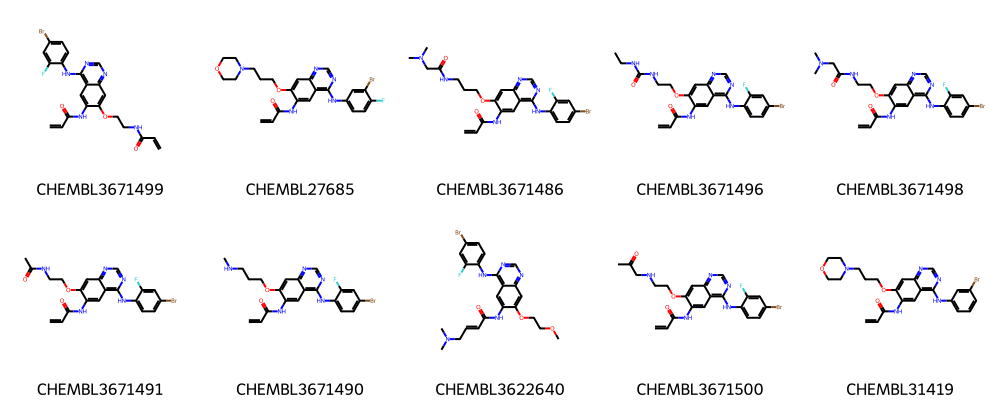

In [9]:
# Show only first 10 molecules -- use slicing
num_mols = 10
legends = [mol.GetProp("_Name") for mol in mols]
Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)

Run the FMCS algorithm with different input parameters
The FMCS algorithm is implemented in RDKit: rdFMCS

Default values
In the simplest case only a list of molecules is given as a parameter.

In [10]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)
# NBVAL_CHECK_OUTPUT

MCS1 contains 24 atoms and 26 bonds.
MCS SMARTS string: [#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]


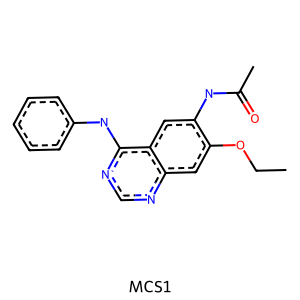

In [11]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

Define a helper function to draw the molecules with the highlighted MCS.

In [12]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

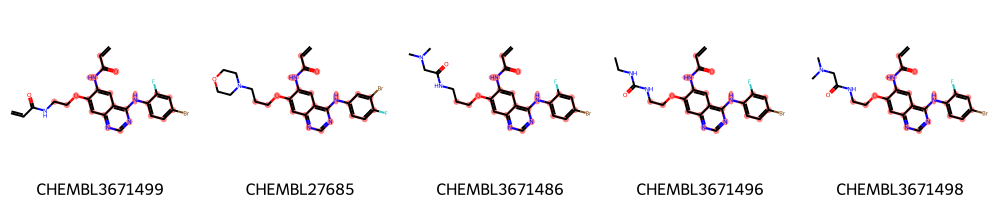

In [13]:
highlight_molecules(mols, mcs1, 5)

In [15]:
#saving image to drive
img = highlight_molecules(mols, mcs1, 3, useSVG=True)

# Get SVG data
molsvg = img.data

# Set background to transparent & Enlarge size of label
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open(DATA / "/content/teachopencadd/teachopencadd/talktorials/T005_compound_clustering/data/mcs_largest_cluster.svg", "w") as f:
    f.write(molsvg)

Set a threshold
It is possible to lower the threshold for the substructure, for example so that the MCS only has to occur in e.g. 80% of the input structures.

In [16]:
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)
# NBVAL_CHECK_OUTPUT

MCS2 contains 28 atoms and 30 bonds.
SMARTS string: [#6]=[#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3-[#9]):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]-[#7]-[#6]


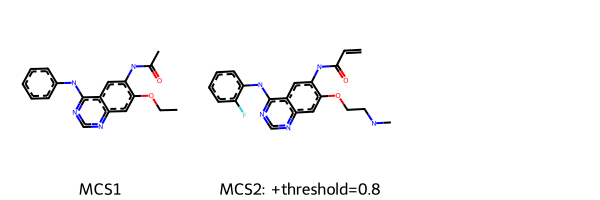

In [17]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

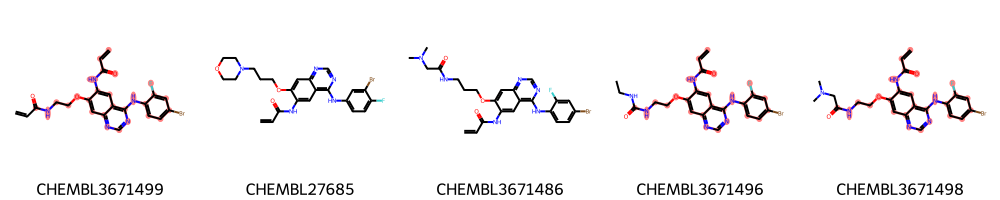

In [18]:
highlight_molecules(mols, mcs2, 5)

As we can see in this example, some molecules were now left out due to the set threshold (0.8). This threshold allows to find a larger common substructure that contains, e.g., a benzene with a meta-substitution fluor pattern and a longer alkane chain.

# **Match ring bonds**
In the above example it may not be obvious, but by default ring bonds can match non-ring bonds. Often from an application point of view, we want to retain rings. Thus, one can set the ringMatchesRingOnly parameter to True, then only ring bonds match with other ring bonds.

In [19]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)
# NBVAL_CHECK_OUTPUT

MCS3 contains 28 atoms and 30 bonds.
SMARTS string: [#6&!R]=&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]2:&@[#6&R](-&!@[#7&!R]-&!@[#6&R]3:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@3-&!@[#9&!R]):&@[#7&R]:&@[#6&R]:&@[#7&R]:&@[#6&R]:&@2:&@[#6&R]:&@[#6&R]:&@1-&!@[#8&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#7&!R]-&!@[#6&!R]


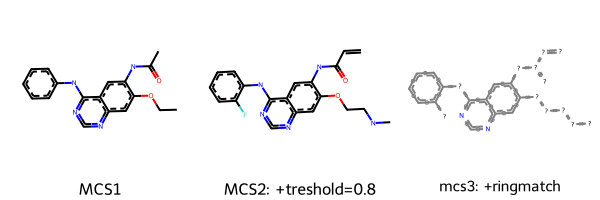

In [20]:
# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

We can see here that depending on the chosen thresholds and parameters, we get slightly different MCS. Note that there are more parameter options available in the RDKit FMCS module, e.g. considering atom, bond or valence matching.

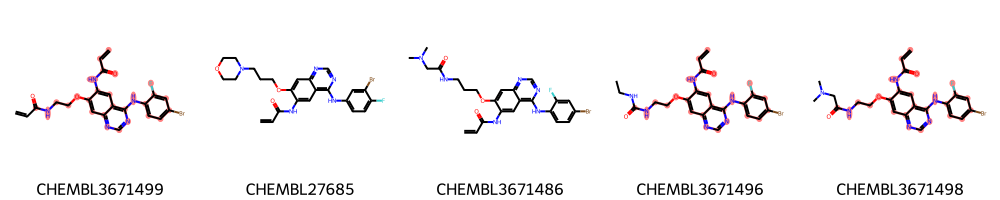

In [21]:
highlight_molecules(mols, mcs3, 5)

A more diverse set: the EGFR compounds downloaded from ChEMBL
We restrict the data to only highly active molecules (pIC50>9) and detect the maximum common scaffold in this subset.

In [22]:
# Read full EGFR data
mol_df = pd.read_csv(HERE / "/content/teachopencadd/teachopencadd/talktorials/T001_query_chembl/data/EGFR_compounds.csv", index_col=0)
print("Total number of compounds:", mol_df.shape[0])

# Only keep molecules with pIC50 > 9 (IC50 > 1nM)
mol_df = mol_df[mol_df.pIC50 > 9]
print("Number of compounds with pIC50 > 9:", mol_df.shape[0])
# NBVAL_CHECK_OUTPUT

Total number of compounds: 5568
Number of compounds with pIC50 > 9: 186


In [23]:
# Add molecule column to data frame
PandasTools.AddMoleculeColumnToFrame(mol_df, "smiles")
mol_df.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,<rdkit.Chem.rdchem.Mol object at 0x7f06f4f87d10>
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,<rdkit.Chem.rdchem.Mol object at 0x7f06f4f87ca0>
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,<rdkit.Chem.rdchem.Mol object at 0x7f06f4f87c30>


In [24]:
mols_diverse = []
# Note: discarded variables we do not care about are usually referred to with a single underscore
for _, row in mol_df.iterrows():
    m = Chem.MolFromSmiles(row.smiles)
    m.SetProp("_Name", row.molecule_chembl_id)
    mols_diverse.append(m)

In [25]:
# We have fixed the random seed above (imports) for deterministic results
mols_diverse_sample = random.sample(mols_diverse, 50)

In [26]:
threshold_diverse = 0.7
mcs1 = rdFMCS.FindMCS(mols_diverse_sample)
print("SMARTS string1:", mcs1.smartsString)
mcs2 = rdFMCS.FindMCS(mols_diverse_sample, threshold=threshold_diverse)
print("SMARTS string2:", mcs2.smartsString)
mcs3 = rdFMCS.FindMCS(mols_diverse_sample, ringMatchesRingOnly=True, threshold=threshold_diverse)
print("SMARTS string3:", mcs3.smartsString)
# NBVAL_CHECK_OUTPUT

SMARTS string1: [#6](:,-[#6]-,:[#7]-,:[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1):,-[#6]:,-[#7]:,-[#6]
SMARTS string2: [#6]:[#6]:[#6]1:[#6](-[#7]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#7]:[#6]:[#7]:[#6]:1:[#6]
SMARTS string3: [#6&R]:&@[#6&R]:&@[#6&R]1:&@[#6&R](-&!@[#7&!R]-&!@[#6&R]2:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@2):&@[#7&R]:&@[#6&R]:&@[#7&R]:&@[#6&R]:&@1:&@[#6&R]


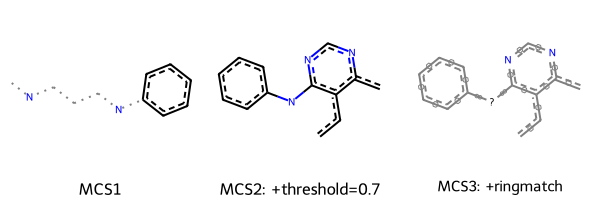

In [27]:
# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage(
    [m1, m2, m3],
    legends=[
        "MCS1",
        f"MCS2: +threshold={threshold_diverse}",
        "MCS3: +ringmatch",
    ],
)

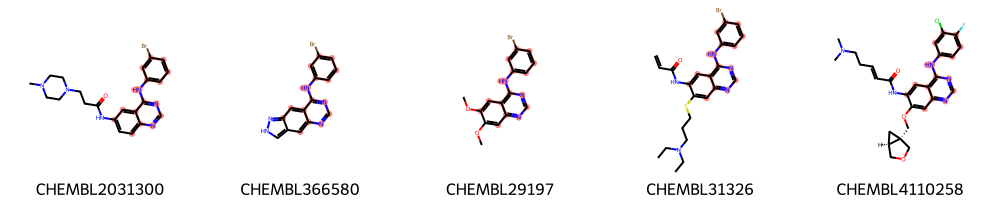

In [28]:
highlight_molecules(mols_diverse_sample, mcs3, 5)

# **Identification of MCS using interactive cut-off adaption**
We can also change the threshold interactively. For that, we need a helper function, hereby defined. It takes two arguments: molecules (fixed, so it's not configurable with a widget) and percentage (the value of which is determined by the interactive widget). Every time you modify the state of the slider, this helper function is called.

In [29]:
def render_mcs(molecules, percentage):
    """Interactive widget helper. `molecules` must be wrapped in `ipywidgets.fixed()`,
    while `percentage` will be determined by an IntSlider widget."""
    tmcs = rdFMCS.FindMCS(molecules, threshold=percentage / 100.0)
    if tmcs is None:
        print("No MCS found")
        return None

    m = Chem.MolFromSmarts(tmcs.smartsString)
    print(tmcs.smartsString)
    return m

In [30]:
# Note that the slider may take a few seconds to react
interact(
    render_mcs,
    molecules=fixed(mols_diverse_sample),
    percentage=widgets.IntSlider(min=0, max=100, step=10, value=70),
);

interactive(children=(IntSlider(value=70, description='percentage', step=10), Output()), _dom_classes=('widget…

# **Discussion**
Maximum substructures that a set of molecules have in common can a useful strategy to visualize common scaffolds. In this talktorial, we have use the FMCS algorithm to find the maximum common substructure within a largest cluster from Tutorial 5. An interactive widget allowed us to explore the impact of different thresholds on the maximum common substructure in our dataset.

